<a href="https://colab.research.google.com/github/AraiKensuke/LOST/blob/master/Notebooks/AR2_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The (implied) prior distribution when we sample from the likelihood of the AR coefficients, ie the prior is uniform over the coefficients***

In [1]:
import sys
import importlib

if importlib.util.find_spec("LOST") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/LOST.git
  %cd /content/LOST

#!python setup.py build_ext --inplace   #  don't need to compile for this notebook

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules

/content
Cloning into 'LOST'...
remote: Enumerating objects: 484, done.
remote: Counting objects: 100% (484/484), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 625 (delta 246), reused 295 (delta 111), pack-reused 141
Receiving objects: 100% (625/625), 44.23 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (317/317), done.
/content/LOST


**The oscillatory AR(2) process can be characterized using several different sets of parameterizations.**  Switching from one set to another involves a change of variables.  In Gibbs sampling, we sample parameters from the conditional posterior distribution, a combination of the conditional likelihood and prior.  Assumption of a flat prior in one set of variables does not translate to a flat prior in another due to the nonlinearity of the variable transformation.  To illustrate this, we sample uniformly from the parameter set modulus and frequency, $r$ and $f$.

Text(0.5, 0, 'frequency $f$')

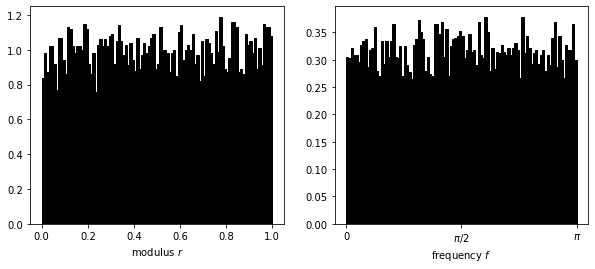

In [10]:
import LOST.ARlib as _arl
from LOST.ARcfSmplFuncs import ampAngRep, buildLims, FfromLims, dcmpcff, initF
import numpy as _N
import matplotlib.pyplot as _plt

#  the actual eigenvalues need | eigenvalue | < 1.  (1 / ev) > 1

N    = 10000
ra   = 0
rb   = 1

#########  imaginary roots
amps  = _N.random.rand(N) * (rb - ra) + ra
phs  = _N.random.rand(N) * _N.pi      #  phs from 0 -> pi   (well, 4pi/N, but large N->0)

fig = _plt.figure(figsize=(10, 4))
fig.add_subplot(1, 2, 1)
_plt.hist(amps, bins=_N.linspace(0, 1, 101), density=True, color="black", edgecolor="black")
_plt.xlabel("modulus $r$")
fig.add_subplot(1, 2, 2)
_plt.hist(phs, bins=_N.linspace(0, 3.1416, 101), density=True, color="black", edgecolor="black")
_plt.xticks([0, _N.pi/2, _N.pi], ["0", "$\pi/2$", "$\pi$"])
_plt.xlabel("frequency $f$")


If we take each sample pair of ($r$, $f$) above, and transform them according 

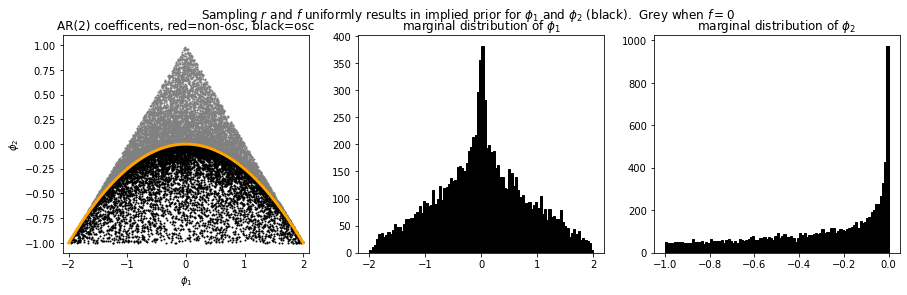

In [5]:

Fsi  = _N.empty((N, 2))

for n in range(N):
    ph = phs[n]
    r1 = amps[n] * (_N.cos(ph) + 1j * _N.sin(ph))
    r2 = amps[n] * (_N.cos(ph) - 1j * _N.sin(ph))

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2]).real
    Fsi[n, 0] = F[0]
    Fsi[n, 1] = F[1]

    # bBdd, iBdd, rts = _arl.cmplxRoots(F)
    # if not bBdd:
    #     print "Woops"


##########  real roots
amps = _N.random.rand(N, k) * (rb - ra) + ra
Fsr  = _N.empty((N, 2))

###  
for n in range(N):
    r1 = -1 + amps[n, 0] * 2
    r2 = -1 + amps[n, 1] * 2

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2])
    Fsr[n, 0] = F[0]
    Fsr[n, 1] = F[1]

#    bBdd, iBdd, rts = _arl.cmplxRoots(F)
#    if not bBdd:
#        print "Woops"

###  Now we take a look at what the marginal distribution of phi_1 and phi_2
###  look like when we sample r and f uniformly.
x = _N.linspace(-2, 2, 201)
#y = 0.25*(4 - x**2) - 1
y = -0.25*x**2
    
#  rts == (1./(r1*r1.conjugate())), (1./(r1*r1.conjugate()))
fig = _plt.figure(figsize=(15, 4))
_plt.suptitle("Sampling $r$ and $f$ uniformly results in implied prior for $\phi_1$ and $\phi_2$ (black).  Grey when $f=0$")
fig.add_subplot(1, 3, 1)
_plt.title("AR(2) coefficents, red=non-osc, black=osc")
_plt.scatter(Fsr[:, 0], Fsr[:, 1], marker=".", s=4, color="grey")
_plt.grid()
_plt.xlim(-2.5, 2.5)
_plt.ylim(-1.5, 1.5)
#fig.add_subplot(1, 2, 2)
_plt.scatter(Fsi[:, 0], Fsi[:, 1], marker=".", s=4, color="black")
_plt.plot(x, y, color="orange", lw=3)
_plt.grid()
_plt.xlim(-2.1, 2.1)
_plt.ylim(-1.1, 1.1)
_plt.xlabel(r"$\phi_1$")
_plt.ylabel(r"$\phi_2$")

fig.add_subplot(1, 3, 2)
_plt.title("marginal distribution of $\phi_1$")
suppress = _plt.hist(Fsi[:, 0], bins=_N.linspace(-2, 2, 101), color="black", edgecolor="black")
fig.add_subplot(1, 3, 3)
_plt.title("marginal distribution of $\phi_2$")
suppress = _plt.hist(Fsi[:, 1], bins=_N.linspace(-1, 0, 101), color="black", edgecolor="black")


components have a frequency and modulus, the higher modulus results in more regular oscillations.  We can sample AR(2) processes, but we need to parameterize the process, and sample the process by sampling the parameter space.  Assuming a uniform prior 

We can either parameterize through AR(2) coefficients $\phi_1, \phi_2$, that lead to a stationary, oscillatory AR(2) process, or through the modulus $r$ and frequency $\lambda$.  These can be expressed as the roots $r_1 = \alpha + i\beta$ and $r_2 = \alpha - i\beta$ of the characteristic polynomial $x^2 + \phi_2 x + \phi_1 = 0$ or the solution of $\begin{pmatrix}r_1 & 1 \\ r_2 &  1\end{pmatrix}\begin{pmatrix}\phi_1 \\ \phi_2\end{pmatrix} = \begin{pmatrix}r_1^2 \\ r_2^2\end{pmatrix}$, where $r = \sqrt{\alpha^2 + \beta^2}$ and $f = \arctan \left(\frac{\beta}{\alpha}\right)$, and $f \in [0, \pi]$ and $r \in [0, 1]$.  

First, we draw frequency and modulus uniformly, and see the corresponding AR(2) coefficients $\phi_1, \phi_2$ where $x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + N(0, \sigma^2)$ and how they're distributed.

If we sample frequencies and modulus uniformly, these don't correspond to a uniform sampling in the coefficent space.  Similarly, if
we sample the coefficient $F_1$, $F_2$, this will lead to a non-uniform sampling of AR(2) processes in the space of frequency and modulus.

First, we sample frequencies and modulus uniformly, and plot out the resulting coefficients, red dots.  Then we sample the modulus with frequency set to 0, black dots.  

Notice that in the above, the black dots don't appear very uniformly distributed in the stationary AR(2) region - it looks denser near the orange boundary between oscillatory and non-oscillatory AR(2) coefficents.

Now let us sample from the stationary oscillatory region.  We'll then examine what distribution of modulus and frequency (wavelength displayed) this will correspond to.

Text(0.5, 0, '$\\lambda$')

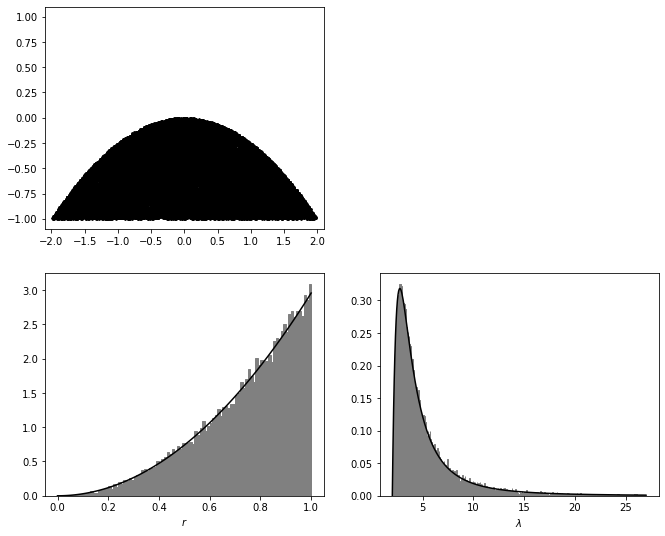

In [ ]:
#  Sample oscillatory AR(2) coefficients

#  First sample uniform [-2, 2] x [-2, 2]
#  Reject if c2 < 0.25*(4-c1**2)-1 or c2 > c1+1 if c1 < 0 
#   or c2 > -c1 + 1 if c1 > 0

N = 100000
c12_cands = _N.empty((N, 2))
c12_cands[:, 0] = 4*(_N.random.rand(N)-0.5)
c12_cands[:, 1] = 2*(_N.random.rand(N)-0.5)

c12 = []
for n in range(N):
    c1 = c12_cands[n, 0]
    c2 = c12_cands[n, 1]

    upper_c2 = 0.25*(4 - c1*c1)-1

    bad = False
    if c2 > upper_c2:
        bad = True
        
    if not bad:
        c12.append([c1, c2])


c12s = _N.array(c12)

#  AR coefficients
#  modulus and angle
#  roots

#  here, I want to turn AR coefficient into modulus and angle pair


Fs=1000
amps = _N.zeros(c12s.shape[0])
fs   = _N.zeros(c12s.shape[0])

#  lambda_u   is n/2 for data length n
#  lambda
for n in range(c12s.shape[0]):
    bBdd, iBdd, mag, F_alfa_rep = _arl.ARroots(_N.array([c12s[n, 0], c12s[n, 1]]))
    prt, rank, f, amp = ampAngRep(F_alfa_rep, 1./(Fs/2), f_order=True)
    amps[n] = amp[0]
    fs[n] = f[0]

#  
#  my fs is between 0 and 1.  lambda is between [2, lambda_u].
#  w = 2pi / lam, so w from 2pi/2=pi   to   2pi/ (N/2) = 4pi/N -> 0
#  w 2pi / 2   pi  to    2pi/(N/2) = 4pi/N

w = fs*_N.pi   
lam = 2*_N.pi / w

fig = _plt.figure(figsize=(11, 9))
fig.add_subplot(2, 2, 1)
_plt.scatter(c12s[:, 0], c12s[:, 1], s=3, color="black")
_plt.xlim(-2.1, 2.1)
_plt.ylim(-1.1, 1.1)
fig.add_subplot(2, 2, 3)
amps_x = _N.linspace(0, 1, 101)
dx = amps_x[1] - amps_x[0]
_plt.hist(amps, bins=_N.linspace(0, 1, 101), color="grey", edgecolor="grey", density=True)
A = _N.sum(amps_x*amps_x*dx)
_plt.plot(amps_x, (1/A) *  amps_x * amps_x, color="black")
_plt.xlabel("$r$")
fig.add_subplot(2, 2, 4)
#lam_x = _N.linspace(2, 52, 101)
lam_x = _N.linspace(2, 27, 401)
dx    = lam_x[1] - lam_x[0]
hist_out = _plt.hist(lam, bins=lam_x, density=True, color="grey", edgecolor="grey")
A = _N.sum((_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x))*dx)
_plt.plot(lam_x, (1/A)*_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x), color="black")
_plt.xlabel("$\lambda$")

Describing the AR(2) in terms of coefficients or by modulus and frequency, we are basically changing variables using $F_1 = 2r \cos\left(\frac{2\pi}{\lambda}\right)$ and $F_2 = -r^2$.  The above marginals for $\lambda$ and $r$ can be derived by looking at the Jacobian,
$\begin{pmatrix}\frac{\partial F_1}{\partial r}  & \frac{\partial F_1}{\partial 
\lambda} \\ \frac{\partial F_2}{\partial r} & \frac{\partial F_2}{\partial \lambda}\end{pmatrix} 
= 
\begin{pmatrix}2 \cos\left(\frac{2\pi}{\lambda}\right)  & \frac{2r \sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2} \\ -2r & 0\end{pmatrix} 
= 
-\frac{4r^2 \sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2}$.  The marginals $p(r) \propto r^2$ and $h(\lambda) \propto \frac{\sin\left(\frac{2\pi}{\lambda}\right)}{\lambda^2}$

For the reverse transformation, mult by 2: hypotenuse=$2\sqrt{-F_2}$, opposite=$\sqrt{-(F_1^2 + 4F_2)}$, adjacent=$F_1$. 

$\begin{pmatrix}\frac{\partial r}{\partial F_1}  & \frac{\partial r}{\partial 
F_2} \\ \frac{\partial \lambda}{\partial F_1} & \frac{\partial \lambda}{\partial F_2}\end{pmatrix} 
= 
\begin{pmatrix}0  & -\frac{1}{2\sqrt{-F_2}} \\ -\frac{1}{\sqrt{-F_1^2 - 4F_2}} & 0\end{pmatrix} 
= 
\frac{1}{\sqrt{-F_2}\sqrt{-F_1^2 - 4F_2}}
-\frac{r^2}{\cos\left(\frac{2\pi}{\lambda}\right)}$.  Unlike for $r$ and $\lambda$, $F_1$ and $F_2$ are constrained in what values they can take, so we must marginalize 



In [ ]:
lam[0:20]

array([ 3.06527631,  3.48923983,  2.8628206 ,  2.1909922 ,  3.26926121,
        2.27161118,  3.12412033,  5.16072469,  3.58120457,  5.12152752,
       21.27309488,  3.31120834,  3.76837853,  9.56712374,  4.17988652,
        5.00508862,  4.96642707,  2.50847232, 17.77493304,  3.3452102 ])

In [ ]:
lam_x[0:20]

array([2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
       2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
       3.    , 3.0625, 3.125 , 3.1875])

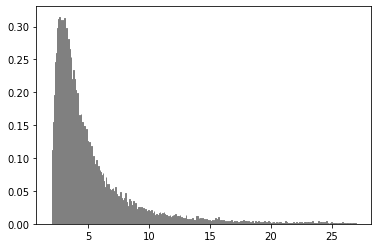

In [ ]:
hist_out = _plt.hist(lam, bins=lam_x, density=True, color="grey", edgecolor="grey")


In [ ]:
_N.where(hist_out[0] == _N.max(hist_out[0]))

(array([10]),)

In [ ]:
hist_out[1][11]

2.6875